In [1]:
from scipy.signal import firwin, lfilter
from scipy.signal import butter, lfilter
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
#import control as ct
np.seterr(divide='ignore', invalid='ignore') #para eliminar warnings respecto a los valores NaN
fftResolution = 1024 #definimos el valor de resolucion de la fft 
from math import log
from scipy.signal import firwin2
from scipy.signal import freqz

## Equations

# Integrator T.F.
 $$H_{I}=\frac{1}{1-z^{1}}$$

# Combinational T.F.
$$H_{C}=1 - z^{-RM}$$

# CIC filter transfer function
$$H(z)=H_{I}^{N}H_{C}^{N}=\frac{(1-z^{-RM})^{N}}{(1-z^{-1})^{N}}=\left [ \sum_{k=0}^{RM-1} z^{-k}\right ]^{N}$$
donde:
* $R$ decimation or interpolation factor.
* $N$ number of the stages of combinational and integration part of the filter.
* $M$ diferential delay 

the z plane mapping of the transfer function is based upon the decimated sampling frequency of the input signal $z=e^{2\pi f/R}$

# Power Response
$$P(f)=\left [ \frac{sin (\pi Mf)}{sin(\pi Mf/R)} \right ]^{2N}$$

### Equations for CIC window implementation
$$ H(\omega) = \left | \frac{sin(\frac{\omega M}{2})}{sin(\frac{\omega}{2R} )} \right |^{N} $$
* $R= 10$
* $N=2$
* $M = 1$
#### The gain of the CIC implementation is defined by:
$$Gain = (MR)^{N}$$

<Figure size 1200x400 with 0 Axes>

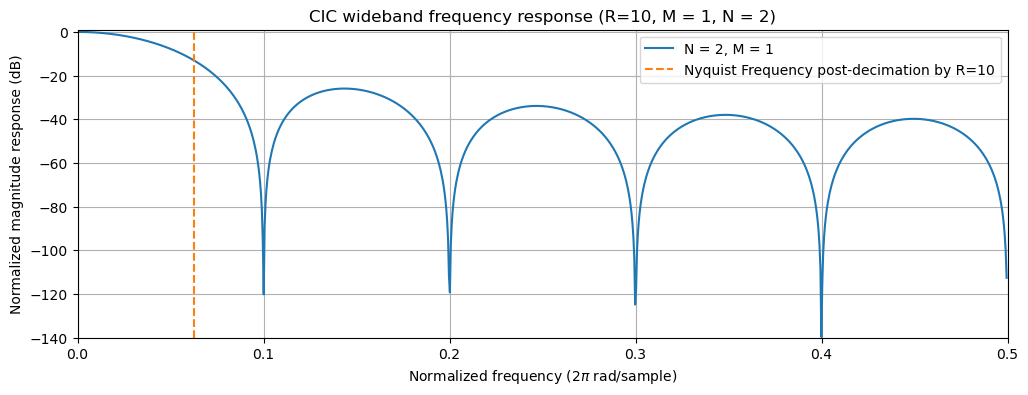

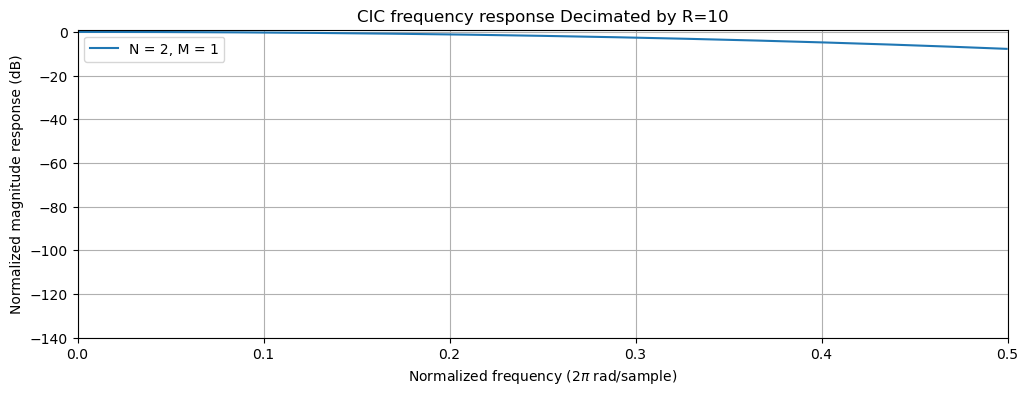

In [2]:

plt.figure(figsize=(12,4))
def plotCICResponse(R,M,N, widebandResponse=1):
    Hfunc = lambda w : np.abs( (np.sin((w*M)/2.)) / (np.sin(w/(2.*R))) )**N
    if widebandResponse:
        #from 0 to R*pi due to the CIC filter response band is extended 
        w = np.arange(fftResolution) * np.pi/fftResolution * R #for wideband response must be divided by the oversapling ratio R
    else:
        # 0 to pi
        w = np.arange(fftResolution) * np.pi/fftResolution
    gain = (M*R)**N #CIC filter gain [1]
    xAxis = np.arange(fftResolution) / (fftResolution * 2) 
    magResponse = np.array(list(map(Hfunc, w)))
    plt.plot(xAxis, 20.0*np.log10(magResponse/gain), label="N = {}, M = {}".format(N,M)) #gain eliminated for a 0 dB response

def plotConfig(title):
    axes = plt.gca(); axes.set_xlim([0,0.5]); axes.set_ylim([-140,1])
    plt.grid(); plt.legend()
    plt.title(title)
    plt.xlabel('Normalized frequency (2$\pi$ rad/sample)')
    plt.ylabel('Normalized magnitude response (dB)')
    plt.show()
    
# Plot 1
plt.figure(figsize=(12,4))
plotCICResponse(R=10,M=1,N=2) 
plt.plot([0.0625,0.0625],[-140,1], '--', label="Nyquist Frequency post-decimation by R=10")
plotConfig("CIC wideband frequency response (R=10, M = 1, N = 2)")
# Plot 3
plt.figure(figsize=(12,4))
plotCICResponse(R=10,M=1,N=2, widebandResponse=0) 
plotConfig("CIC frequency response Decimated by R=10")

### Observation: we can see that the gain of ther CIC filter is supresed for plotting porpuse, the gain and frequency response is equally derived usign the equations of [1] even if we are usign the CRRS or cascaded combinational recursive running sum structure of [2].

## Compensation filter design
#### Due to the CIC filter have a gain of  $RM^{N}$ we need to multiply by the same coeficient to get the inverse filter response, other aproach normally used is round and truncation of the filter output.
#### the compensation filter are tipically placed in the low sampling frequency (decimated frenquency), in this case due to the implementation is a decimation filter the compensation stage is placed after the CIC implementation. 
#### the ideal atenuation of the pass band and the filter response is showned
$$ \left | H(j\omega) \right | = (RM^{N}) \left | \frac{sin(\frac{\omega}{2R})}{sin(\frac{\omega M }{2})} \right |^{N}$$

Complete Response


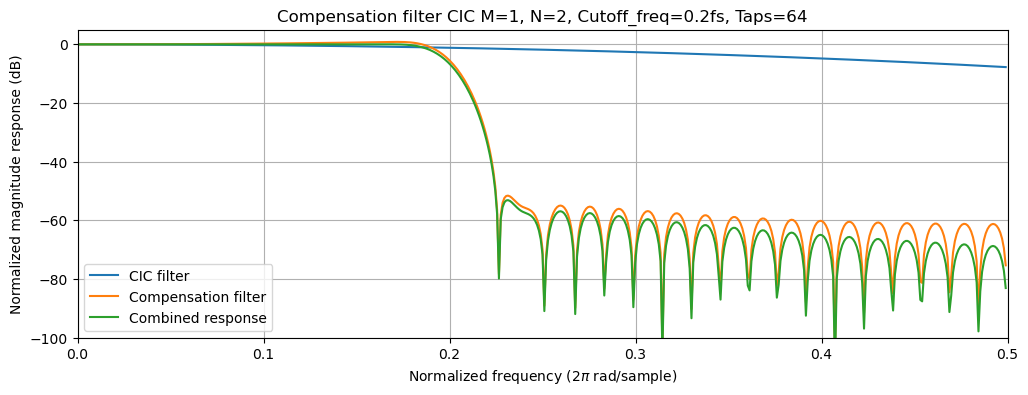

Closer look to see the ripple in the pass band


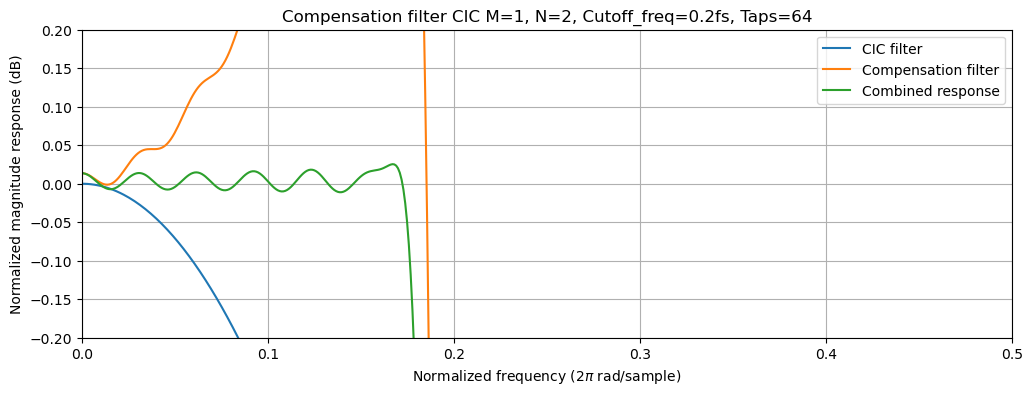

In [3]:
#the cutoff is based in the decimated nyquist frequency
def getFIRCompensationFilter(R,M,N,cutOff,numTaps,calcRes=20000):
    #CalcRes comple la misma funcion de la resolucion de la fft.
    w = np.arange(calcRes) * np.pi/(calcRes - 1)    
    Hcomp = lambda w : ((M*R)**N)*(np.abs((np.sin(w/(2.*R))) / (np.sin((w*M)/2.)) ) **N)
    cicCompResponse = np.array(list(map(Hcomp, w)))
    # replace dc response to 1 to avoid NaN valuerror
    cicCompResponse[0] = 1
    # we equal to zero the frequencies outside the cutoff frequency  (stopband)
    cicCompResponse[int(calcRes*cutOff*2):] = 0        
    normFreq = np.arange(calcRes) / (calcRes - 1)
    taps = firwin2(numTaps, normFreq, cicCompResponse) #get filter taps 
    return taps

def plotFIRCompFilter(R,M,N,cutOff,taps, yMin, yMax, wideband=False):    
    
    plt.figure(figsize=(12,4))
    
    if wideband:        
        interp = np.zeros(len(taps)*R)
        interp[::R] = taps
        freqs,response = freqz(interp)
    else:
        freqs,response = freqz(taps)
    
    if wideband:
        w = np.arange(len(freqs)) * np.pi/len(freqs) * R
    else:
        w = np.arange(len(freqs)) * np.pi/len(freqs)
        
    Hcic = lambda w : (1/((M*R)**N))*np.abs( (np.sin((w*M)/2.)) / (np.sin(w/(2.*R))) )**N
    cicMagResponse = np.array(list(map(Hcic, w)))

    combinedResponse = cicMagResponse * response
    
    plt.plot(freqs/(2*np.pi),20*np.log10(abs(cicMagResponse)), label="CIC filter")
    plt.plot(freqs/(2*np.pi),20*np.log10(abs(response)), label="Compensation filter")
    plt.plot(freqs/(2*np.pi),20*np.log10(abs(combinedResponse)), label="Combined response")
    axes = plt.gca(); axes.set_xlim([0,0.5]); axes.set_ylim([yMin,yMax])
    plt.grid(); plt.legend()
    plt.title("Compensation filter CIC M={}, N={}, Cutoff_freq={}fs, Taps={}".format(M,N,cutOff,len(taps)))
    plt.xlabel('Normalized frequency (2$\pi$ rad/sample)')
    plt.ylabel('Normalized magnitude response (dB)')
    plt.show()

taps = getFIRCompensationFilter(R=10,M=1,N=2,cutOff=0.2,numTaps=64);
print("Complete Response")
plotFIRCompFilter(R=10,M=1,N=2,cutOff=0.2,taps=taps,yMin=-100,yMax=5)
print("Closer look to see the ripple in the pass band")
plotFIRCompFilter(R=10,M=1,N=2,cutOff=0.2,taps=taps,yMin=-0.2,yMax=0.2)

#### Observation: we can use the same taps in the received signal from behavioral and implemented design on the fpga, and then apply only a high pass filter to eliminate the dc component if is needed.

### Behavioral simulation Results of the CRRS filter.

In [4]:
fs = 4.8e6 #a sampling frequency of 4.8 Mhz
f0 = 40e3 #a signal of 40 khz
N = 2**14 #number of samples 16384
w = 2*np.pi*f0/fs*np.arange(0,N) #rad conversion
stim = 0.5*np.cos(w)+1 #signal generaton with offset to be positive


In [5]:
IMPULSE_HEIGHT = np.amax(stim) #max abs value 
THRESHOLD = IMPULSE_HEIGHT/2 #generation trshold for sigma delta modulation

output_pdm = np.zeros(N)
running_sum = 0

for i, sample in enumerate(stim):
    running_sum = running_sum + sample
    if running_sum > THRESHOLD:
        running_sum = running_sum - IMPULSE_HEIGHT
        output_pdm[i] = 1
        
#optional code to save pdm data into a .txt, the data samples are already integrated in a .mem file in vivado        
#with open('pdm.txt', 'w') as fd:
#    for i, sample in enumerate(stim):
#        running_sum = running_sum + sample
#        if running_sum > THRESHOLD:
#            running_sum = running_sum - IMPULSE_HEIGHT
#            output_pdm[i] = 1

#        fd.write(f"{int(output_pdm[i])}\n")

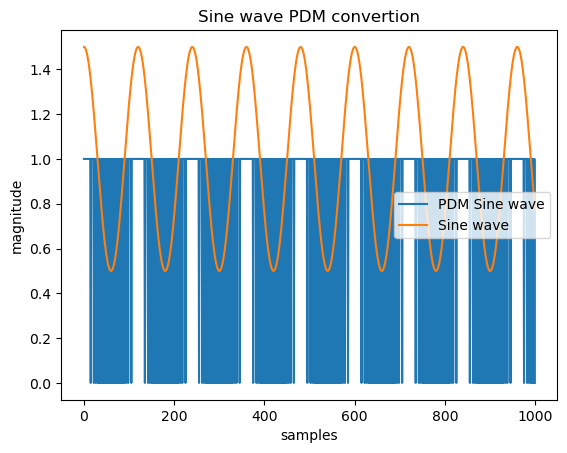

In [6]:
fig, ax = plt.subplots()
line_output_pdm = ax.plot(output_pdm[0:1000], label='PDM Sine wave')
line_stim = ax.plot(stim[0:1000], label='Sine wave')

ax.set_title('Sine wave PDM convertion')

ax.set_xlabel('samples')
ax.set_ylabel('magnitude')

ax.legend()


In [7]:
pcm_time = []
decpcm_time = []
pcm_data=[]
pdm_data = []
dec_pcm_data = []
dec_pcm_data0 = [] 
pcmline = []
with open("behavioral_data.txt", "r") as file:
    lines = file.readlines()\
#creating data list with monitor values, resultion of 1 [ps]    
for line in lines:
        time_pcm,clk,mclk,ce_pdm,ce_pcm,rst,we,pdm,pcm,dec_pcm = line.strip().split(",")
        time_pcm = int(time_pcm.split("=")[1])
        ce_pdm = int(ce_pdm.split("=")[1])
        clk = int(clk.split("=")[1])
        ce_pcm = int(ce_pcm.split("=")[1])
        pcm = int(pcm.split("=")[1])
        dec_pcm = int(dec_pcm.split("=")[1])
        pdm = int(pdm.split("=")[1])
        if clk == 1:
            if ce_pdm == 1:
                pcm_data.append(pcm)
                pcm_time.append(time_pcm)
                dec_pcm_data0.append(dec_pcm)
                pdm_data.append(pdm)
            if ce_pcm == 1:
                dec_pcm_data.append(dec_pcm)
                decpcm_time.append(time_pcm)

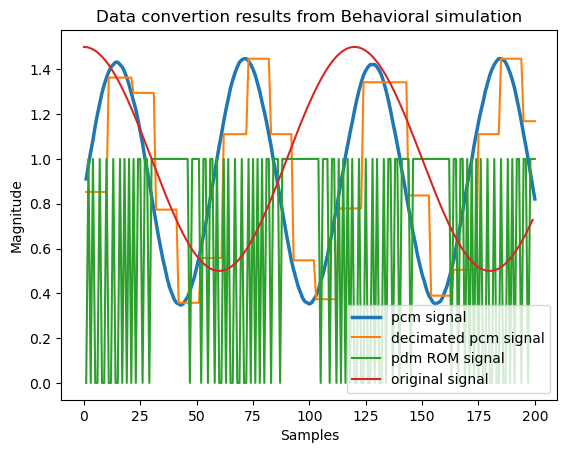

In [8]:
#fig, ax = plt.subplots()
sim_time = np.linspace(1,4960,4960) #number of samples of simulation time.
sim_time1 = np.linspace(1,4860,4860)
pdm = pdm_data
pcm = np.array(pcm_data)/(100*3.8)
dec_pcm = np.array(dec_pcm_data0)/(100*3.8)
plt.plot(sim_time[0:200],pcm[0:200],label = 'pcm signal',linewidth=2.5)
plt.plot(sim_time1[0:200],dec_pcm[0:200],label ='decimated pcm signal')
plt.plot(sim_time[0:200],pdm_data[0:200],label = 'pdm ROM signal')
plt.plot(stim[0:200],label ='original signal')

plt.xlabel('Samples')
plt.ylabel('Magnitude')
plt.title('Data convertion results from Behavioral simulation')
plt.legend()

plt.show()

### Observation: at this point for ploting porpuse the signals are normalized. further when aplyting correct filtering the signals will be correctly displayed.

### Signal Filtering
#### At this point the conversion from pdm to pcm and decimation of the signal is done, so a compensation filtering is applied to remove de dc compontent and upper frecuencies (the signal of interest is 40 Khz). the we applied the magnitud compensation of $\frac{1}{Gain}$

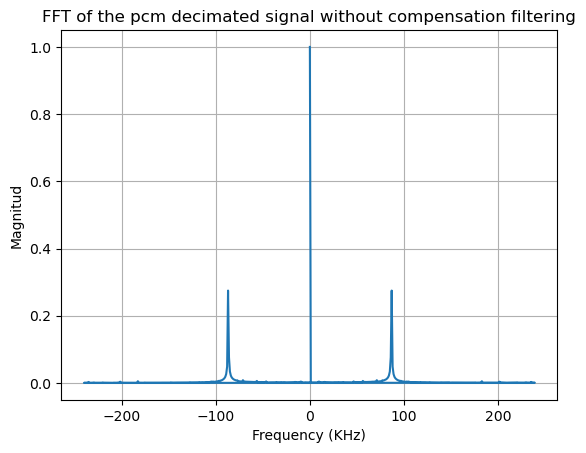

In [9]:
fs = 480000 #decimated by 10 sampling frequency
fft_result = np.fft.fft(dec_pcm_data)
frequencies = np.fft.fftfreq(len(dec_pcm_data), 1/fs)
plt.plot(frequencies/1000, np.abs(fft_result)/max(abs(fft_result)))
plt.xlabel('Frequency (KHz)')
plt.ylabel('Magnitud')
plt.title('FFT of the pcm decimated signal without compensation filtering')
plt.grid()
plt.show()

### Observation: at this point we see a clean frequency response, this because is a behavioral simulation, further when we receive the samples from the implemented design on the FPGA, some issues related to imagin appear but is solved in the compensation filtering stage. in this ocation we choose a butterworth windows IIR filter.


<Figure size 1000x600 with 0 Axes>

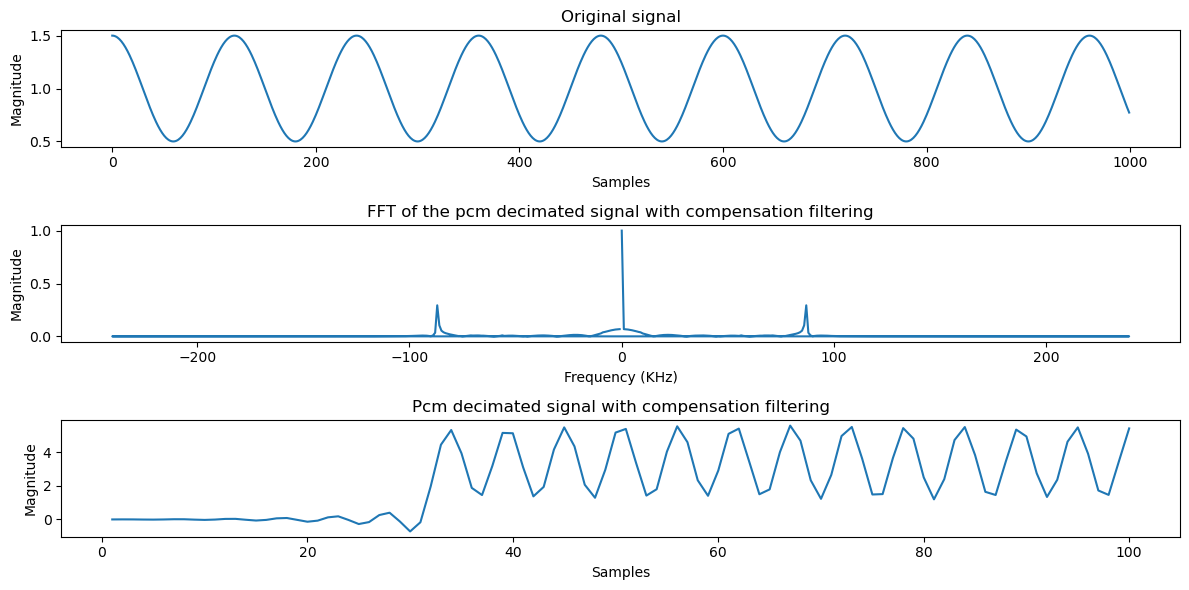

In [10]:
fs = 480e3  # sampling frequency
t =np.linspace(1,len(dec_pcm_data),len(dec_pcm_data))
# compensation filtering
filtered_data = lfilter(taps, 1.0, dec_pcm_data)
fft_result = np.fft.fft(filtered_data)
frequencies = np.fft.fftfreq(len(filtered_data), 1/fs)
N=2
R=10
M=1
gain=(R*M)**N
plt.figure(figsize=(10, 6))
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(stim[0:1000])
plt.title("Original signal")
plt.xlabel('Samples')
plt.ylabel('Magnitude')
plt.subplot(3, 1, 2)
plt.plot(frequencies/1000, np.abs(fft_result)/max(abs(fft_result)))
plt.title("FFT of the pcm decimated signal with compensation filtering")
plt.xlabel('Frequency (KHz)')
plt.ylabel('Magnitude')
plt.subplot(3, 1, 3)
plt.plot(t[0:100], (filtered_data[0:100])/(gain))
plt.title("Pcm decimated signal with compensation filtering")
plt.xlabel('Samples')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

#### Observation: we can see that the frecuency component of 40 Khz is present in the filtered signal, there is a sligth more gain in the pcm converted signal of aproximate  $gain = 6.14$ this happend due to the quantization error, we can see the corresponding signal with some delay samples due to the fir filtering computing. Both signals have a dc component as we can see in the fft 

In [11]:
#find the two bigger frequency components 
num_peaks = 2  
peaks_idx = np.argsort(np.abs(fft_result))[-num_peaks:]

largest_freqs = frequencies[peaks_idx]

print(f'Fundamental frequency component : {largest_freqs[0]} and his relative error : {abs(1- 40e3/largest_freqs[0])*100} %')


Fundamental frequency component : 86913.58024691358 and his relative error : 53.97727272727273 %


### Post-Implementation test results of the CRRS filter.

In [12]:
pcm_hw = []  #list of the hardware pcm filter values from zynq7000 device

with open("memory_test.txt", "r") as file:
    for line in file:
        num = int(line)
        pcm_hw.append(num)
    #    line = line.strip()  
    #    if line:  
    #        parts = line.split("=")  
    #        if len(parts) == 2:  
    #            numeric_value = int(parts[1].strip())  
    #pcm_hw.append(line)  


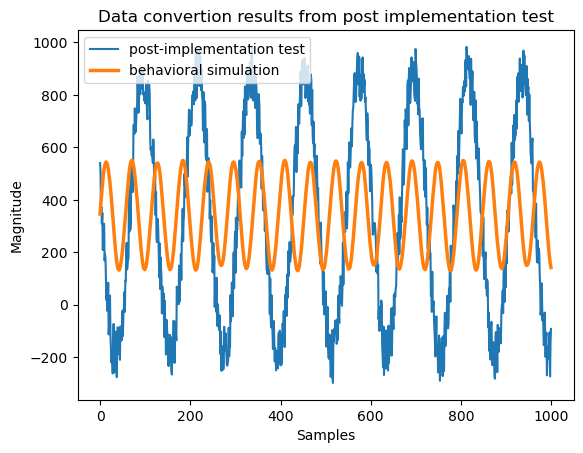

In [13]:
t = np.linspace(0,2000,2000)
pcm_hw = np.array(pcm_hw)
plt.plot(t[0:1000],pcm_hw[0:1000],label='post-implementation test')
plt.plot(t[0:1000],pcm_data[0:1000],label = 'behavioral simulation',linewidth=2.5)
plt.xlabel('Samples')
plt.ylabel('Magnitude')
plt.title('Data convertion results from post implementation test')
plt.legend()

plt.show()

In [14]:
#FFT of the hardware signal
fs = 4.8e6
fft_result = np.fft.fft(pcm_hw)
frequencies = np.fft.fftfreq(len(pcm_hw), 1/fs)

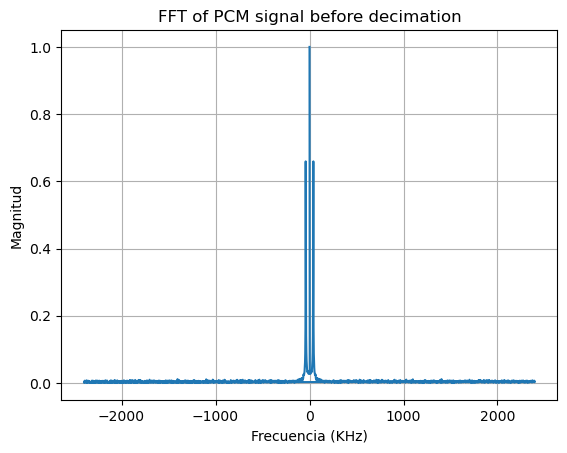

In [15]:
# Graficar la magnitud de la FFT
plt.plot(frequencies/1000, np.abs(fft_result)/max(abs(fft_result)))
plt.xlabel('Frecuencia (KHz)')
plt.ylabel('Magnitud')
plt.title('FFT of PCM signal before decimation')
plt.grid()
plt.show()

In [16]:
#find the two bigger frequency components 
num_peaks = 2  
peaks_idx = np.argsort(np.abs(fft_result))[-num_peaks:]

largest_freqs = frequencies[peaks_idx]

print(f'Fundamental frequency component : {largest_freqs[0]} and his relative error : {abs(1- 40e3/abs(largest_freqs[0]))*100} %')

Fundamental frequency component : -40800.0 and his relative error : 1.9607843137254943 %


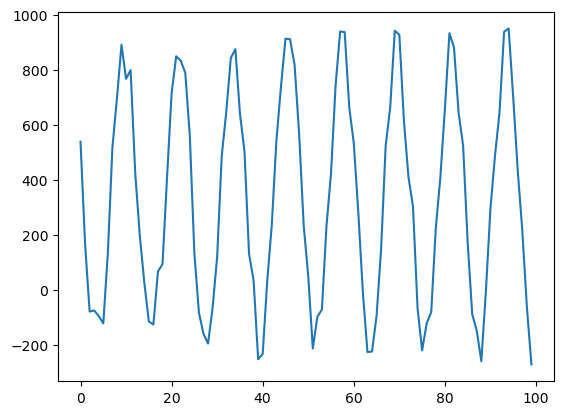

In [17]:
dec_hw = pcm_hw[::10]
t = np.linspace(0,2000,2000)
plt.plot(t[0:100],dec_hw[0:100])
plt.show()

In [18]:
# Obtener la FFT de la señal
fs = 480e3
dec_fft = np.fft.fft(dec_hw)
dec_freq = np.fft.fftfreq(len(dec_hw), 1/fs)

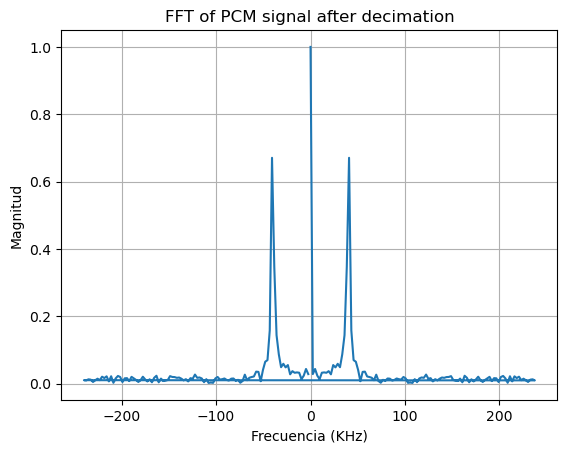

In [19]:
# Graficar la magnitud de la FFT
plt.plot(dec_freq/1000, np.abs(dec_fft)/max(abs(dec_fft)))
plt.xlabel('Frecuencia (KHz)')
plt.ylabel('Magnitud')
plt.title('FFT of PCM signal after decimation')
plt.grid()
plt.show()

In [20]:
# FIR compensation filter 
fs = 4.8e3
t =np.linspace(1,len(dec_hw),len(dec_hw))
# applying fir filter 
filtered_signal = lfilter(taps, 1.0, dec_hw)
fft_result = np.fft.fft(filtered_signal)
frequencies = np.fft.fftfreq(len(filtered_signal), 1/fs)

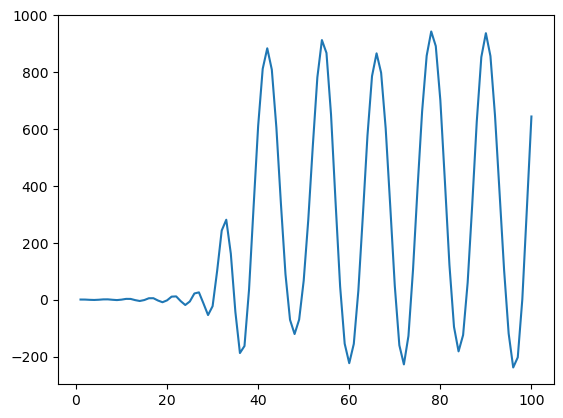

In [21]:
plt.plot(t[0:100],filtered_signal[0:100])
plt.show()

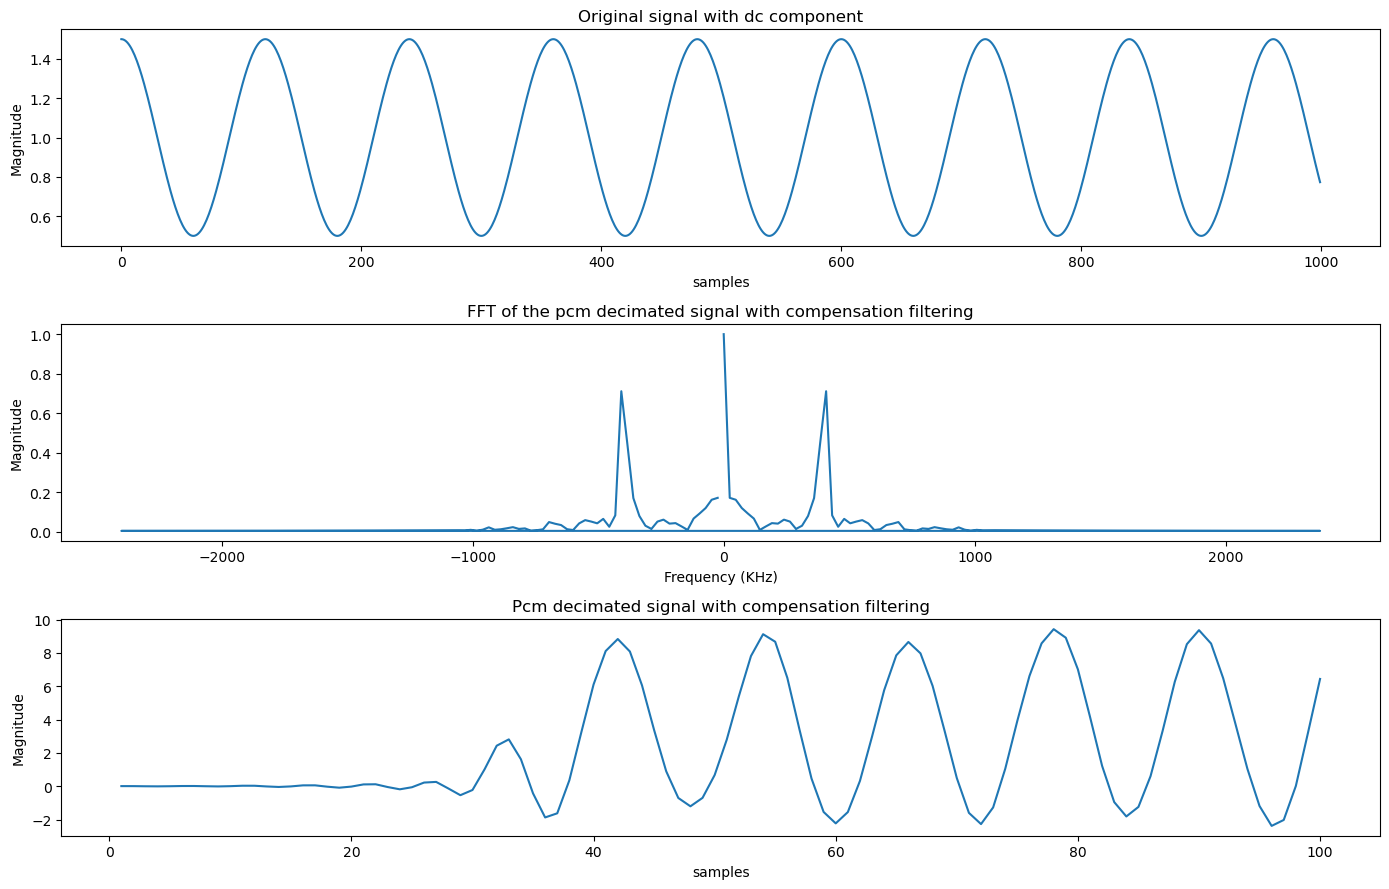

In [22]:
# Graficar la señal original, la FFT y la señal filtrada
plt.figure(figsize=(14, 9))
plt.subplot(3, 1, 1)
plt.plot(stim[0:1000])
plt.title("Original signal with dc component")
plt.xlabel('samples')
plt.ylabel('Magnitude')
plt.subplot(3, 1, 2)
plt.plot(frequencies, np.abs(fft_result)/max(abs(fft_result)))
plt.title("FFT of the pcm decimated signal with compensation filtering")
plt.xlabel('Frequency (KHz)')
plt.ylabel('Magnitude')
plt.subplot(3, 1, 3)
plt.plot(t[0:100], (filtered_signal[0:100]/(gain)))
plt.title("Pcm decimated signal with compensation filtering")
plt.xlabel('samples')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

### Observation : even if we can still distinguished the original signal after the conversion, we can see the frequency components are haveily disturbed with the frecuencies near the dc component. we cna still stract the frequency of interest doing some more filtering stages removing the low frequency spectrum. But is necesary mention that some of the noise can be present due to the quantization noise error and some variations in the clock generation (jitter)

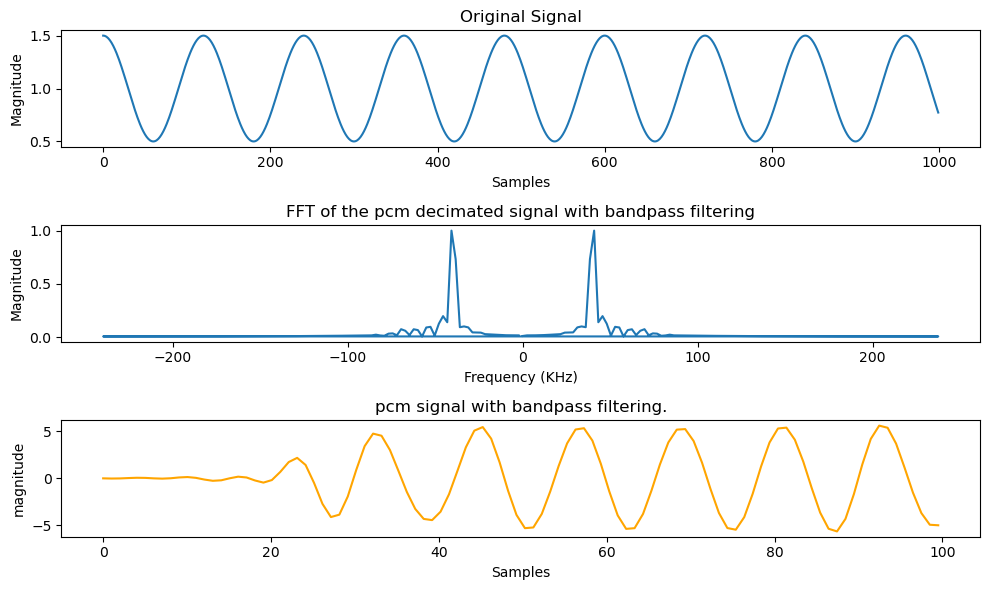

In [23]:
from scipy.signal import firwin, lfilter

# Parámetros del filtro
num_taps = 64  # Número de taps del filtro FIR
f1 = 30000 # Frecuencia de corte inferior en Hz
f2 = 80000  # Frecuencia de corte superior en Hz
fs = 480000  # Frecuencia de muestreo en Hz

# Diseñar el filtro FIR pasabanda
nyquist_freq = 0.5 * fs
low_cutoff = f1 / nyquist_freq
high_cutoff = f2 / nyquist_freq
filter_taps = firwin(num_taps, [low_cutoff, high_cutoff], pass_zero=False)
t = np.linspace(0,len(filtered_signal),len(filtered_signal))
# Aplicar el filtro FIR pasabanda
filtered_signal0 = lfilter(filter_taps, 1.0, filtered_signal)


fft_result = np.fft.fft(filtered_signal0)
frequencies = np.fft.fftfreq(len(filtered_signal0), 1/fs)
# Gráficos de la señal original y la señal filtrada
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(stim[0:1000])
plt.title('Original Signal')
plt.xlabel('Samples')
plt.ylabel('Magnitude')

plt.subplot(3,1,2)
plt.plot(frequencies/1000, np.abs(fft_result)/max(abs(fft_result)))
plt.title("FFT of the pcm decimated signal with bandpass filtering")
plt.xlabel('Frequency (KHz)')
plt.ylabel('Magnitude')

plt.subplot(3, 1, 3)
plt.plot(t[0:100], filtered_signal0[40:140]/gain, color='orange')
plt.title('pcm signal with bandpass filtering.')
plt.xlabel('Samples')
plt.ylabel('magnitude')

plt.tight_layout()
plt.show()


In [24]:
#find the two bigger frequency components 
num_peaks = 2  
peaks_idx = np.argsort(np.abs(fft_result))[-num_peaks:]

largest_freqs = frequencies[peaks_idx]

print(f'Fundamental frequency component : {largest_freqs[1]} and his relative error : {abs(1- 40000/abs(largest_freqs[1]))*100} %')

Fundamental frequency component : -40800.0 and his relative error : 1.9607843137254943 %


### Observation : we can see the signal output from a bandpass filter with some frequency shifting of 1.96% of variation of the original signal, this could happend because the exact clock frequency from the system and the decimated clock frequency are not the equally, this can cause variation in the filter response parameters that are tunned by the original sampling frequency.